In [1]:
# Julia V1.0.1
using CSV, DataFrames, Gadfly, GLM, Distributions

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/Jonathan/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1186


In [8]:
data = CSV.read("Titanic_train.csv");

In [9]:
# Deux variables indicatrices pour la classe des passagers

Pclass = collect(skipmissing(data[:Pclass]))
n = length(Pclass)
X₁ = zeros(n)
X₂ = zeros(n)
for i in eachindex(Pclass) 
    if Pclass[i]==2
        X₂[i] = 1
    elseif Pclass[i]==1
        X₁[i] = 1
    end   
end

# Estimation des paramètres par maximum de la vraisemblance
## Modèle de régression logistique avec le lien logit

In [10]:
X = hcat(ones(n),X₁,X₂)

# On stocke les données dans un dataframe pour utiliser la package GLM de Julia
df = DataFrame(X₁=X₁,X₂=X₂,Y=data[:Survived])

logit = glm(@formula(Y ~ X₁+X₂), df, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Y ~ 1 + X₁ + X₂

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -1.13977  0.105316 -10.8224   <1e-26
X₁             1.6704   0.17591  9.49574   <1e-20
X₂            1.03097   0.18137  5.68434    <1e-7


In [11]:
# Estimation des probabilité de survie par classe

β̂ = coef(logit)
x₁ = [1 1 0];
p₁ = exp.(x₁*β̂)./(1 .+ exp.(x₁*β̂))
println("Un passager de la première classe a une probabilité de $p₁ de survivre.")
x₂ = [1 0 1];
p₂ = exp.(x₂*β̂)./(1 .+ exp.(x₂*β̂))
println("Un passager de la deuxième classe a une probabilité de $p₂ de survivre.")
x₃ = [1 0 0];
p₃ = exp.(x₃*β̂)./(1 .+ exp.(x₃*β̂))
println("Un passager de la troisième classe a une probabilité de $p₃ de survivre.")

Un passager de la première classe a une probabilité de [0.62963] de survivre.
Un passager de la deuxième classe a une probabilité de [0.472826] de survivre.
Un passager de la troisième classe a une probabilité de [0.242363] de survivre.


# Estimation des paramètres par maximum de la vraisemblance
## Modèle de régression logistique avec le lien probit

In [12]:
X = hcat(ones(n),X₁,X₂)

# On stocke les données dans un dataframe pour utiliser la package GLM de Julia
df = DataFrame(X₁=X₁,X₂=X₂,Y=data[:Survived])

probit = glm(@formula(Y ~ X₁+X₂), df, Binomial(), ProbitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},ProbitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Y ~ 1 + X₁ + X₂

Coefficients:
              Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -0.698723 0.0618591 -11.2954   <1e-28
X₁              1.0296  0.106743  9.64559   <1e-21
X₂            0.630555  0.111256   5.6676    <1e-7


In [15]:
# Estimation des probabilité de survie par classe

β̂ = coef(probit)
x₁ = [1 1 0];
p₁ = cdf.(Normal(),(x₁*β̂))
println("Un passager de la première classe a une probabilité de $p₁ de survivre.")
x₂ = [1 0 1];
p₂ = cdf.(Normal(),(x₂*β̂))
println("Un passager de la deuxième classe a une probabilité de $p₂ de survivre.")
x₃ = [1 0 0];
p₃ = cdf.(Normal(),(x₃*β̂))
println("Un passager de la troisième classe a une probabilité de $p₃ de survivre.")

Un passager de la première classe a une probabilité de [0.62963] de survivre.
Un passager de la deuxième classe a une probabilité de [0.472826] de survivre.
Un passager de la troisième classe a une probabilité de [0.242363] de survivre.


## Sélection de la fonction de lien

In [19]:
Y = convert(Array{Float64},data[:Survived])

β̂ = coef(logit)
θ = exp.(X*β̂)./(1 .+ exp.(X*β̂))
f = Bernoulli.(θ)
BIC_logit = sum(logpdf.(f,Y)) - 2/2*log(n) 


β̂ = coef(probit)
θ = cdf.(Normal(0,1),X*β̂)
f = Bernoulli.(θ)
BIC_probit = sum(logpdf.(f,Y)) - 2/2*log(n) 

if BIC_logit>BIC_probit
    println("Le modèle avec le lien logit est meilleur.")
else
    println("Le modèle avec le lien probit est meilleur.")
end

Le modèle avec le lien logit est meilleur.


# Prédiction pour l'échantillon de test avec le modèle logit

In [21]:
# Prédiction de la survie pour les passagers de l'échantillon de test

test = CSV.read("Titanic_test.csv")

Pclass = collect(skipmissing(test[:Pclass]))
n = length(Pclass)
X₁ = zeros(n)
X₂ = zeros(n)
for i in eachindex(Pclass) 
    if Pclass[i]==2
        X₂[i] = 1
    elseif Pclass[i]==1
        X₁[i] = 1
    end   
end

X = hcat(ones(n),X₁,X₂)

β̂ = coef(logit)

θ̂ = exp.(X*β̂)./(1 .+ exp.(X*β̂))
Ŷ = zeros(Int64,n)
Ŷ[θ̂.>.5] .= 1

prediction = DataFrame(PassengerId = test[:PassengerId], Survived = Ŷ)
CSV.write("Titanic_prediction.csv",prediction)

"Titanic_prediction.csv"

# Estimation bayésienne des paramètres de la régression logistique

In [23]:
data = CSV.read("Titanic_train.csv");

# Deux variables indicatrices pour la classe des passagers

Pclass = collect(skipmissing(data[:Pclass]))
n = length(Pclass)
X₁ = zeros(Int64,n)
X₂ = zeros(Int64,n)
for i in eachindex(Pclass) 
    if Pclass[i]==2
        X₂[i] = 1
    elseif Pclass[i]==1
        X₁[i] = 1
    end   
end

X = hcat(ones(Int64,n),X₁,X₂)
Y = collect(skipmissing(data[:Survived]));

In [24]:
function nlogf(Y::Array{Int64,1},X::Array{Int64,2},β₀::Float64,β₁::Float64,β₂::Float64)
    β = vcat(β₀,β₁,β₂)
    sum(Y.*(X*β) .- log1p.(exp.(X*β)))
end

nlogf (generic function with 1 method)

In [25]:
NITER = 1000

δ₀ = Normal(0,.15)
δ₁ = Normal(0,.25)
δ₂ = Normal(0,.25)

β = zeros(3,NITER)
acc = falses(3,NITER)

nlogf(Y,X,β[:,1]...)


for i=2:NITER
   
    # Générer un candidat pour β₀
    β̃₀ = β[1,i-1] + rand(δ₀)
    
    ρ̃ = nlogf(Y,X,β̃₀,β[2,i-1],β[3,i-1]) - nlogf(Y,X,β[1,i-1],β[2,i-1],β[3,i-1])
    
    if ρ̃ > log(rand(Uniform(0,1)))
        β[1,i] = β̃₀
        acc[1,i]=true
    else
        β[1,i] = β[1,i-1]
    end
    
    # Générer un candidat pour β₁
    β̃₁ = β[2,i-1] + rand(δ₁)
    
    ρ̃ = nlogf(Y,X,β[1,i],β̃₁,β[3,i-1]) - nlogf(Y,X,β[1,i],β[2,i-1],β[3,i-1])
    
    if ρ̃ > log(rand(Uniform(0,1)))
        β[2,i] = β̃₁
        acc[2,i]=true
    else
        β[2,i] = β[2,i-1]
    end
    
    # Générer un candidat pour β₂
    β̃₂ = β[3,i-1] + rand(δ₂)
    
    ρ̃ = nlogf(Y,X,β[1,i],β[2,i],β̃₂) - nlogf(Y,X,β[1,i],β[2,i],β[3,i-1])
    
    if ρ̃ > log(rand(Uniform(0,1)))
        β[3,i] = β̃₂
        acc[3,i]=true
    else
        β[3,i] = β[3,i-1]
    end
        
end

taux = mean(acc, dims = 2)

println("Le taux d'acceptation de β₀ est de $(taux[1]).")
println("Le taux d'acceptation de β₁ est de $(taux[2]).")
println("Le taux d'acceptation de β₂ est de $(taux[3]).")

Le taux d'acceptation de β₀ est de 0.483.
Le taux d'acceptation de β₁ est de 0.533.
Le taux d'acceptation de β₂ est de 0.551.


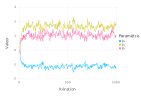

In [26]:
df = DataFrame(Itération=collect(1:NITER), β₀ = β[1,:], β₁ = β[2,:], β₂ = β[3,:])
mcmc = stack(df,2:4)
rename!(mcmc, :value => :Valeur, :variable => :Paramètre)

plot(mcmc, x=:Itération, y=:Valeur, color=:Paramètre, Geom.line)

In [27]:
WARMUP = 100

# Estimations ponctuelles bayésiennes des paramètres
β̂ = mean(β[:,WARMUP+1:NITER], dims=2)

# Estimations ponctuelles des probabilités de survie par classe
x₁ = [1 1 0];
p₁ = exp.(x₁*β̂)./(1 .+ exp.(x₁*β̂))
println("Un passager de la première classe a une probabilité de $p₁ de survivre.")
x₂ = [1 0 1];
p₂ = exp.(x₂*β̂)./(1 .+ exp.(x₂*β̂))
println("Un passager de la deuxième classe a une probabilité de $p₂ de survivre.")
x₃ = [1 0 0];
p₃ = exp.(x₃*β̂)./(1 .+ exp.(x₃*β̂))
println("Un passager de la troisième classe a une probabilité de $p₃ de survivre.")

Un passager de la première classe a une probabilité de [0.627282] de survivre.
Un passager de la deuxième classe a une probabilité de [0.475406] de survivre.
Un passager de la troisième classe a une probabilité de [0.241915] de survivre.
